<a href="https://colab.research.google.com/github/zizizw/SupplyChainHW/blob/main/BioPharma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import Packages


In [ ]:
import requests
from datetime import datetime, timedelta, date
import pandas as pd
from scipy.stats import multivariate_normal

In [ ]:
%reset -f
# Install and import packages
!pip install gurobipy
!pip install tabulate

import pandas as pd
import numpy as np
from gurobipy import Model, GRB, quicksum
from tabulate import tabulate
import datetime as dt
_empty_series = pd.Series(dtype=float)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 33.4 MB/s eta 0:00:00


# Get Exchange Rates

In [ ]:
def get_month_end_dates(start_date_str, end_date_str):
    """
    Generate a list of dates representing the last day of each month
    between start_date and end_date. If the end_date falls in the middle
    of a month, that date will be used for the final month.
    """
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d').date()
    end_date   = datetime.strptime(end_date_str, '%Y-%m-%d').date()
    month_end_dates = []

    # Start from the first day of the month of start_date.
    current = start_date.replace(day=1)

    while current <= end_date:
        # Determine the first day of the next month.
        if current.month == 12:
            next_month = date(current.year + 1, 1, 1)
        else:
            next_month = date(current.year, current.month + 1, 1)

        # Last day of the current month is one day before the first day of the next month.
        last_day_of_month = next_month - timedelta(days=1)

        # If the last day of the month is after the specified end_date,
        # then use end_date (if it is in the same month) instead.
        if last_day_of_month > end_date:
            last_day_of_month = end_date

        if last_day_of_month >= start_date:
            month_end_dates.append(last_day_of_month)

        # Move to the first day of the next month.
        current = next_month

    return month_end_dates

def get_exchange_rate_for_date(date_str, base_currency="USD", symbols=None):
    """
    Fetches exchange rates for the given date from the Frankfurter API.

    :param date_str: The date string in 'YYYY-MM-DD' format.
    :param base_currency: The base currency (default "USD").
    :param symbols: A list of target currency codes.
    :return: A dictionary of exchange rates.
    """
    url = f"https://api.frankfurter.app/{date_str}"
    params = {"from": base_currency}
    if symbols:
        params["to"] = ",".join(symbols)

    response = requests.get(url, params=params)

    if response.status_code == 200:
        data = response.json()
        return data.get("rates", {})
    else:
        print(f"Error fetching data for {date_str}: HTTP {response.status_code}")
        return {}

def estimate_statistics(exchange_data):
    """
    Given a dictionary of exchange rate data with dates as keys and
    rate dictionaries as values, this function computes:

      - The average exchange rate vector.
      - The variance-covariance matrix of the exchange rates.

    :param exchange_data: dict of the form {date_str: {currency: rate, ...}, ...}
    :return: A tuple (average_vector, covariance_matrix) where:
             - average_vector is a pandas Series.
             - covariance_matrix is a pandas DataFrame.
    """
    # Convert the nested dictionary to a pandas DataFrame.
    # Rows are indexed by date and columns are the currency codes.
    df = pd.DataFrame.from_dict(exchange_data, orient="index")
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)

    # Calculate the average exchange rate for each currency.
    average_vector = df.mean()

    # Calculate the variance-covariance matrix of the exchange rates.
    covariance_matrix = df.cov()

    return average_vector, covariance_matrix



In [ ]:
# Specify the time period and target currencies.
start_date_str = "2023-01-01"  # Change to your desired start date.
end_date_str   = "2024-12-31"  # Change to your desired end date.
target_currencies = ["BRL", "EUR", "INR", "JPY", "MXN"]

# Get a list of month-end dates for the given period.
month_end_dates = get_month_end_dates(start_date_str, end_date_str)

# Dictionary to hold the results.
exchange_data = {}

# Fetch the exchange rates for each month-end date.
for d in month_end_dates:
    date_str = d.isoformat()
    print(f"Fetching rates for {date_str}...")
    rates = get_exchange_rate_for_date(date_str, base_currency="USD", symbols=target_currencies)
    exchange_data[date_str] = rates

# Display the collected exchange rate data.
print("\nExchange Rates at Month End:")
for date_str, rates in exchange_data.items():
    print(f"{date_str}: {rates}")

# Estimate average exchange rate vector and the variance-covariance matrix.
avg_vector, cov_matrix = estimate_statistics(exchange_data)

print("\nAverage Exchange Rate Vector:")
print(avg_vector)

print("\nVariance-Covariance Matrix:")
print(cov_matrix)

Fetching rates for 2023-01-31...
Fetching rates for 2023-02-28...
Fetching rates for 2023-03-31...
Fetching rates for 2023-04-30...
Fetching rates for 2023-05-31...
Fetching rates for 2023-06-30...
Fetching rates for 2023-07-31...
Fetching rates for 2023-08-31...
Fetching rates for 2023-09-30...
Fetching rates for 2023-10-31...
Fetching rates for 2023-11-30...
Fetching rates for 2023-12-31...
Fetching rates for 2024-01-31...
Fetching rates for 2024-02-29...
Fetching rates for 2024-03-31...
Fetching rates for 2024-04-30...
Fetching rates for 2024-05-31...
Fetching rates for 2024-06-30...
Fetching rates for 2024-07-31...
Fetching rates for 2024-08-31...
Fetching rates for 2024-09-30...
Fetching rates for 2024-10-31...
Fetching rates for 2024-11-30...
Fetching rates for 2024-12-31...

Exchange Rates at Month End:
2023-01-31: {'BRL': 5.1115, 'EUR': 0.92311, 'INR': 81.82, 'JPY': 130.41, 'MXN': 18.8277}
2023-02-28: {'BRL': 5.2058, 'EUR': 0.94171, 'INR': 82.61, 'JPY': 136.76, 'MXN': 18.3143}


# Question 1: Sample 100 draws

In [ ]:
mvn_distribution = multivariate_normal(mean=avg_vector, cov=cov_matrix)
sample = mvn_distribution.rvs(size=100, random_state = 1) # change size from 1 to 100 to get 100 draws

print("Sampled draw:", sample)

Sampled draw: [[  5.06667254   0.8999488   82.71303795 133.8740746   18.64681926]
 [  5.0041597    0.93691491  83.86457595 164.81646318  15.97401017]
 [  5.65305259   0.90553434  83.51728346 135.06415756  20.46286718]
 [  5.44377568   0.92357617  84.21577755 155.26906678  18.24055268]
 [  5.05926617   0.9181068   82.92188648 155.39498121  16.85127807]
 [  5.33209095   0.92013514  83.96083184 152.00526976  18.14599946]
 [  5.37794971   0.93466353  84.03469959 152.05753064  18.53296205]
 [  5.75525184   0.92651571  83.6987428  146.70453307  19.44377478]
 [  5.69388485   0.93573721  84.0042625  148.10139275  19.03576189]
 [  5.29433132   0.92119983  82.76626483 151.72786791  18.17063588]
 [  5.24370369   0.92453229  83.56348752 144.26575384  18.32642054]
 [  4.87698721   0.90832313  82.06785782 142.13716123  17.10773002]
 [  4.88978804   0.9171997   82.78864015 152.67640844  16.65443978]
 [  5.05898227   0.95146317  82.10291729 147.36278118  16.83736836]
 [  5.70113098   0.93490014  84.25

Convert to exrate dataFrame

In [ ]:
# Assuming target_currencies is a list of the target currencies
target_currencies = ["BRL", "EUR", "INR", "JPY", "MXN"]

# Convert the sample array to a DataFrame
sample_df = pd.DataFrame(sample, columns=target_currencies)

# Add a new column 'USD' with all values set to 1
sample_df['USD'] = 1

# Add base_yr_data at the last row
base_yr_data = {
    'BRL': 4.33,
    'EUR': 0.92,
    'INR': 71.48,
    'JPY': 109.82,
    'MXN': 18.65,
    'USD': 1
}

# Adding the new row using loc
sample_df.loc[len(sample_df)] = base_yr_data

# Print the updated DataFrame
print("Exrate DataFrame:")
print(sample_df)

Exrate DataFrame:
          BRL       EUR        INR         JPY        MXN  USD
0    5.066673  0.899949  82.713038  133.874075  18.646819    1
1    5.004160  0.936915  83.864576  164.816463  15.974010    1
2    5.653053  0.905534  83.517283  135.064158  20.462867    1
3    5.443776  0.923576  84.215778  155.269067  18.240553    1
4    5.059266  0.918107  82.921886  155.394981  16.851278    1
..        ...       ...        ...         ...        ...  ...
96   5.568773  0.908408  83.715529  142.538406  19.281732    1
97   4.830415  0.935455  81.613486  142.130019  16.755331    1
98   5.052838  0.946380  83.034853  147.523095  17.227551    1
99   5.038200  0.921457  84.128855  153.152105  17.188413    1
100  4.330000  0.920000  71.480000  109.820000  18.650000    1

[101 rows x 6 columns]


# Raw Data

In [ ]:
exrate = sample_df.copy()
demand = pd.DataFrame({
    'from': ['LatinAmerica', 'Europe', 'AsiaWoJapan', 'Japan', 'Mexico', 'U.S.'],
    'd_h': [7, 15, 5, 7, 3, 18],
    'd_r': [7, 12, 3, 8, 3, 17],
})
demand.set_index('from', inplace=True)

caps = pd.DataFrame({
    'plant': ['Brazil', 'Germany', 'India', 'Japan', 'Mexico', 'U.S.'],
    'cap': [18, 45, 18, 10, 30, 22],
})
caps.set_index('plant', inplace=True)

pcosts = pd.DataFrame({
    'plant': ['Brazil', 'Germany', 'India', 'Japan', 'Mexico', 'U.S.'],
    'fc_p': [20, 45, 14, 13, 30, 23],
    'fc_h': [5, 13, 3, 4, 6, 5],
    'fc_r': [5, 13, 3, 4, 6, 5],
    'rm_h': [3.6, 3.9, 3.6, 3.9, 3.6, 3.6],
    'pc_h': [5.1, 6.0, 4.5, 6.0, 5.0, 5.0],
    'rm_r': [4.6, 5.0, 4.5, 5.1, 4.6, 4.5],
    'pc_r': [6.6, 7.0, 6.0, 7.0, 6.5, 6.5],
})
pcosts.set_index('plant', inplace=True)

tcosts = pd.DataFrame({
    'from': ['Brazil', 'Germany', 'India', 'Japan', 'Mexico', 'U.S.'],
    'LatinAmerica': [0.20, 0.45, 0.50, 0.50, 0.40, 0.45],
    'Europe': [0.45, 0.20, 0.35, 0.40, 0.30, 0.30],
    'AsiaWoJapan': [0.50, 0.35, 0.20, 0.30, 0.50, 0.45],
    'Japan': [0.50, 0.40, 0.30, 0.10, 0.45, 0.45],
    'Mexico': [0.40, 0.30, 0.50, 0.45, 0.20, 0.25],
    'U.S.': [0.45, 0.30, 0.45, 0.45, 0.25, 0.20],
})
tcosts.set_index('from', inplace=True)

duties = pd.DataFrame({
    'from': ['LatinAmerica', 'Europe', 'AsiaWoJapan', 'Japan', 'Mexico', 'U.S.'],
    'duty': [0.30, 0.03, 0.27, 0.06, 0.35, 0.04],
})
duties.set_index('from', inplace=True)

plant_currency = {
    'Brazil': 'BRL',
    'Germany': 'EUR',
    'India': 'INR',
    'Japan': 'JPY',
    'Mexico': 'MXN',
    'U.S.': 'USD'}

# Functions

In [ ]:
# identify number of supply and demand location for iterations
n_ctry = range(demand.shape[0])
n_lines = range(demand.shape[1]+1)

# Objective function to calculate cost
def calc_total_cost(dec_plant, dec_h, dec_r, selected_row=0, tariff=0):
    x_plant = np.array(list(dec_plant.values())).reshape(len(n_ctry), len(n_lines))
    x_h = np.array(list(dec_h.values())).reshape(len(n_ctry), len(n_ctry))
    x_r = np.array(list(dec_r.values())).reshape(len(n_ctry), len(n_ctry))

    # Adjust the cost using exchange rate of selected_row based on year 2019
    reindx = exrate.loc[100] / exrate.loc[selected_row]

    pcosts_rev = pcosts.values * reindx.values.reshape(-1,1)
    pcosts_rev = pd.DataFrame(pcosts_rev, columns=pcosts.columns[0:], index=pcosts.index)
    # return pcosts_rev
    # pcosts_rev = adj_pcosts_exrate(2019, 2023)

    duties_mat = np.zeros(len(duties)) + (1 + duties['duty'].values)[:, np.newaxis]
    np.fill_diagonal(duties_mat, 1)
    duties_mat = pd.DataFrame(duties_mat.T, index=pcosts_rev.index, columns=duties.index)
    # no additional tariffs between US and EU
    # duties_mat.loc['Germany', 'U.S.'] += tariff
    # duties_mat.loc['U.S.', 'Europe']  += tariff

    vcosts_h = tcosts.add(pcosts_rev['rm_h'], axis=0).add(pcosts_rev['pc_h'], axis=0) * duties_mat
    vcosts_r = tcosts.add(pcosts_rev['rm_r'], axis=0).add(pcosts_rev['pc_r'], axis=0) * duties_mat

    fc = pcosts_rev[['fc_p','fc_h','fc_r']].values
    vh = (vcosts_h * x_h).values
    vr = (vcosts_r * x_r).values
    total_cost = sum(0.2 * fc[i,j] for i in n_ctry for j in n_lines) + sum(0.8 * fc[i,j] * x_plant[i,j] for i in n_ctry for j in n_lines) + sum(vh[i,j] for i in n_ctry for j in n_ctry) + sum(vr[i,j] for i in n_ctry for j in n_ctry)

    return total_cost


# Calculate excess capacity given decision variables
def calc_excess_cap(dec_plant, dec_h, dec_r):
    x_plant = np.array(list(dec_plant.values())).reshape(len(n_ctry), len(n_lines))
    x_h = np.array(list(dec_h.values())).reshape(len(n_ctry), len(n_ctry))
    x_r = np.array(list(dec_r.values())).reshape(len(n_ctry), len(n_ctry))

    excess_cap = (x_plant * caps.values).copy()
    excess_cap[:, 0] -= (np.sum(x_h, axis=1) + np.sum(x_r, axis=1))
    excess_cap[:, 1] -= np.sum(x_h, axis=1)
    excess_cap[:, 2] -= np.sum(x_r, axis=1)
    return excess_cap

# Calculate unmet demand given decision variables
def calc_unmet_demand(dec_h, dec_r):
    x_h = np.array(list(dec_h.values())).reshape(len(n_ctry), len(n_ctry))
    x_r = np.array(list(dec_r.values())).reshape(len(n_ctry), len(n_ctry))

    x_h_sum = np.sum(x_h, axis=0)
    x_r_sum = np.sum(x_r, axis=0)
    unmet_demand = (demand.values).copy()
    unmet_demand = np.column_stack((x_h_sum - unmet_demand[:, 0], x_r_sum - unmet_demand[:, 1]))

    return unmet_demand


# Question 1: Get optimal network configuration

In [ ]:
scenario_results = []

# Loop through each scenario in the exrate DataFrame
for scenario_index in range(100):
    try:
        # Create a Gurobi model
        model = Model("MinimizeCost")

        # Define decision variables
        dec_plant = {(i, j): model.addVar(vtype=GRB.BINARY, name=f"Dec_plant_{i}_{j}") for i in n_ctry for j in n_lines}
        dec_h = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"Dec_h_{i}_{j}") for i in n_ctry for j in n_ctry}
        dec_r = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"Dec_r_{i}_{j}") for i in n_ctry for j in n_ctry}

        # Add constraints
        excess_cap = calc_excess_cap(dec_plant, dec_h, dec_r)
        for i in n_ctry:
            for j in n_lines:
                model.addConstr(excess_cap[i, j] >= 0, name=f"Excess_Cap_Constraints_{i}_{j}")

        unmet_demand = calc_unmet_demand(dec_h, dec_r)
        for i in n_ctry:
            for j in range(2):
                model.addConstr(unmet_demand[i, j] == 0, name=f"Unmet_Demand_Constraints_{i}_{j}")

        # Set objective function
        model.setObjective(calc_total_cost(dec_plant, dec_h, dec_r, scenario_index), GRB.MINIMIZE)

        # Suppress optimization output
        model.Params.OutputFlag = 0

        # Optimize the model
        model.optimize()

        # Extract results
        op_plant = pd.DataFrame([[dec_plant[i, j].x for j in n_lines] for i in n_ctry], columns=['Plant', 'H', 'R'], index=caps.index)
        op_h = pd.DataFrame([[dec_h[i, j].x for j in n_ctry] for i in n_ctry], columns=tcosts.columns, index=tcosts.index)
        op_r = pd.DataFrame([[dec_r[i, j].x for j in n_ctry] for i in n_ctry], columns=tcosts.columns, index=tcosts.index)

        # Store results
        scenario_results.append({
            "Scenario": scenario_index,
            "HighCal_Flow": op_h,
            "Relax_Flow": op_r,
            "Strategy": op_plant,
            "Minimum_Cost": round(model.objVal, 2)
        })

        # Print results
        print(f"\nScenario {scenario_index} - HighCal Flow\n")
        print(tabulate(op_h, headers='keys', tablefmt='pretty'))
        print(f"\nScenario {scenario_index} - Relax Flow\n")
        print(tabulate(op_r, headers='keys', tablefmt='pretty'))
        print(f"\nScenario {scenario_index} - Strategy\n")
        print(tabulate(op_plant, headers='keys', tablefmt='pretty'))
        print(f"\nScenario {scenario_index} - Minimum Cost: $ {round(model.objVal, 2)}")

    except Exception as e:
        print(f"Error optimizing scenario {scenario_index}: {e}")
        continue


Scenario 0 - HighCal Flow

+---------+--------------+--------+-------------+-------+--------+------+
|  from   | LatinAmerica | Europe | AsiaWoJapan | Japan | Mexico | U.S. |
+---------+--------------+--------+-------------+-------+--------+------+
| Brazil  |     7.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
| Germany |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
|  India  |     0.0      |  0.0   |     5.0     |  0.0  |  0.0   | 0.0  |
|  Japan  |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
| Mexico  |     0.0      |  15.0  |     0.0     |  3.0  |  3.0   | 0.0  |
|  U.S.   |     0.0      |  0.0   |     0.0     |  4.0  |  0.0   | 18.0 |
+---------+--------------+--------+-------------+-------+--------+------+

Scenario 0 - Relax Flow

+---------+--------------+--------+-------------+-------+--------+------+
|  from   | LatinAmerica | Europe | AsiaWoJapan | Japan | Mexico | U.S. |
+---------+--------------+--------+-------------+-------+-

# Question 2: Propose 3 candidate network strategies

In [ ]:
# Initialize a dictionary to store the sum of all 'Strategy' values
strategy_sum = None

# Loop through each scenario to sum up the 'Strategy' values
for scenario in scenario_results:
    strategy_df = scenario['Strategy']

    if strategy_sum is None:
        # Initialize the sum with the first scenario's 'Strategy' DataFrame
        strategy_sum = strategy_df.copy()
    else:
        # Add the current scenario's 'Strategy' DataFrame to the sum
        strategy_sum += strategy_df

# Calculate the average by dividing the sum by the number of scenarios
num_scenarios = len(scenario_results)
strategy_avg = strategy_sum / num_scenarios


# Print the average table
print("\nAverage Strategy Across All Scenarios\n")
print(tabulate(round(strategy_avg, 2), headers='keys', tablefmt='pretty'))


Average Strategy Across All Scenarios

+---------+-------+------+------+
|  plant  | Plant |  H   |  R   |
+---------+-------+------+------+
| Brazil  |  1.0  | 1.0  | 1.0  |
| Germany |  1.0  | 0.33 | 0.93 |
|  India  |  1.0  | 1.0  | 1.0  |
|  Japan  |  1.0  | 0.02 | 1.0  |
| Mexico  | 0.68  | 0.68 | 0.68 |
|  U.S.   | 0.98  | 0.91 | 0.28 |
+---------+-------+------+------+


In [ ]:
# Threshold 1
strategy_avg_threshold_1 = (strategy_avg >= 0.9).astype(int)

# Threshold 2
strategy_avg_threshold_2 = (strategy_avg >= 0.6).astype(int)

# Threshold 3
strategy_avg_threshold_3 = (strategy_avg >= 0.3).astype(int)

# Define a function to update the plant column
def update_plant_column(df):
    df['Plant'] = ((df['H'] | df['R']) > 0).astype(int)
    return df

# Apply the function to each DataFrame
strategy_avg_threshold_1 = update_plant_column(strategy_avg_threshold_1)
strategy_avg_threshold_2 = update_plant_column(strategy_avg_threshold_2)
strategy_avg_threshold_3 = update_plant_column(strategy_avg_threshold_3)

# Printing the updated DataFrames
print("DataFrame with Threshold 0.9 Classification:")
print(strategy_avg_threshold_1)

print("\nDataFrame with Threshold 0.6 Classification:")
print(strategy_avg_threshold_2)

print("\nDataFrame with Threshold 0.3 Classification:")
print(strategy_avg_threshold_3)



DataFrame with Threshold 0.9 Classification:
         Plant  H  R
plant               
Brazil       1  1  1
Germany      1  0  1
India        1  1  1
Japan        1  0  1
Mexico       0  0  0
U.S.         1  1  0

DataFrame with Threshold 0.6 Classification:
         Plant  H  R
plant               
Brazil       1  1  1
Germany      1  0  1
India        1  1  1
Japan        1  0  1
Mexico       1  1  1
U.S.         1  1  0

DataFrame with Threshold 0.3 Classification:
         Plant  H  R
plant               
Brazil       1  1  1
Germany      1  1  1
India        1  1  1
Japan        1  0  1
Mexico       1  1  1
U.S.         1  1  0


# Question 2: Identify pairs

In [ ]:
print("\nVariance-Covariance Matrix:")
print(cov_matrix)


Variance-Covariance Matrix:
          BRL       EUR       INR        JPY       MXN
BRL  0.150618  0.002509  0.273974   1.225555  0.435292
EUR  0.002509  0.000251  0.005125   0.046274  0.004548
INR  0.273974  0.005125  0.754891   4.657418  0.664957
JPY  1.225555  0.046274  4.657418  61.585064  0.535588
MXN  0.435292  0.004548  0.664957   0.535588  1.553693


In [ ]:
# Initialize an empty list to store the reshaped strategy data
strategy_data = []

# Loop through each scenario
for scenario in scenario_results:
    # Extract the 'Strategy' DataFrame
    strategy_df = scenario['Strategy']

    # Reshape the DataFrame to a single row
    reshaped_row = {}
    for plant in strategy_df.index:
        for col in strategy_df.columns:
            reshaped_row[f"{plant}_{col}"] = strategy_df.loc[plant, col]

    # Add the scenario number to the reshaped row
    reshaped_row['Scenario'] = scenario['Scenario']

    # Append the reshaped row to the list
    strategy_data.append(reshaped_row)

# Convert the list of reshaped rows to a DataFrame
combined_strategy_df = pd.DataFrame(strategy_data)

# Set 'Scenario' as the index
combined_strategy_df.set_index('Scenario', inplace=True)

# Display the combined DataFrame
print(combined_strategy_df)

          Brazil_Plant  Brazil_H  Brazil_R  Germany_Plant  Germany_H  \
Scenario                                                               
0                  1.0       1.0       1.0            1.0       -0.0   
1                  1.0       1.0       1.0            1.0        1.0   
2                  1.0       1.0       1.0            1.0        0.0   
3                  1.0       1.0       1.0            1.0        0.0   
4                  1.0       1.0       1.0            1.0        1.0   
...                ...       ...       ...            ...        ...   
95                 1.0       1.0       1.0            1.0       -0.0   
96                 1.0       1.0       1.0            1.0        0.0   
97                 1.0       1.0       1.0            1.0        1.0   
98                 1.0       1.0       1.0            1.0        1.0   
99                 1.0       1.0       1.0            1.0        1.0   

          Germany_R  India_Plant  India_H  India_R  Japan_Plant

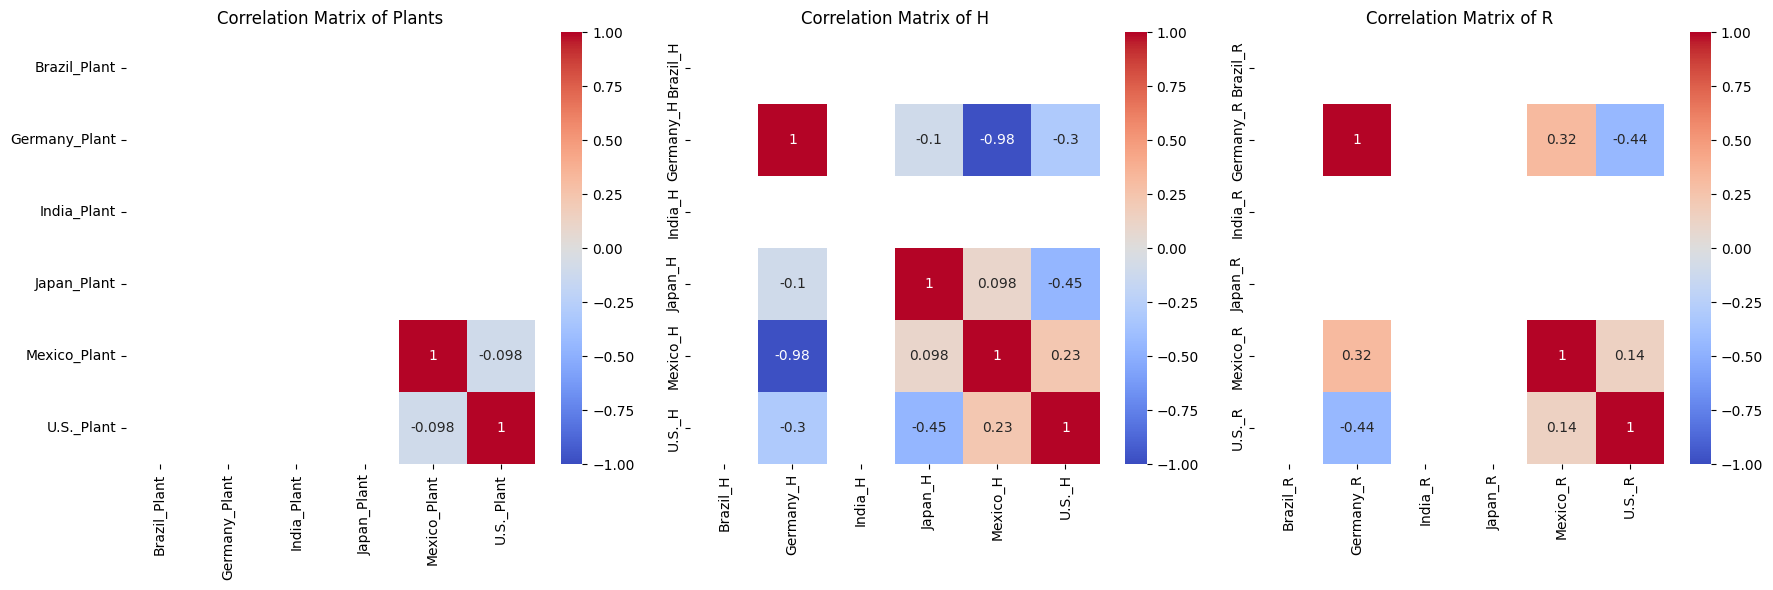

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Grouping columns based on the names (plants, H, and R)
plant_columns = [col for col in combined_strategy_df.columns if 'Plant' in col]
H_columns = [col for col in combined_strategy_df.columns if 'H' in col]
R_columns = [col for col in combined_strategy_df.columns if 'R' in col]

# Compute the correlation matrix for each group
correlation_plant = combined_strategy_df[plant_columns].corr()
correlation_H = combined_strategy_df[H_columns].corr()
correlation_R = combined_strategy_df[R_columns].corr()

# Plotting the heatmaps
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.heatmap(correlation_plant, annot=True, cmap='coolwarm', ax=axs[0], cbar=True, vmin=-1, vmax=1)
axs[0].set_title('Correlation Matrix of Plants')

sns.heatmap(correlation_H, annot=True, cmap='coolwarm', ax=axs[1], cbar=True, vmin=-1, vmax=1)
axs[1].set_title('Correlation Matrix of H')

sns.heatmap(correlation_R, annot=True, cmap='coolwarm', ax=axs[2], cbar=True, vmin=-1, vmax=1)
axs[2].set_title('Correlation Matrix of R')

plt.tight_layout()
plt.show()


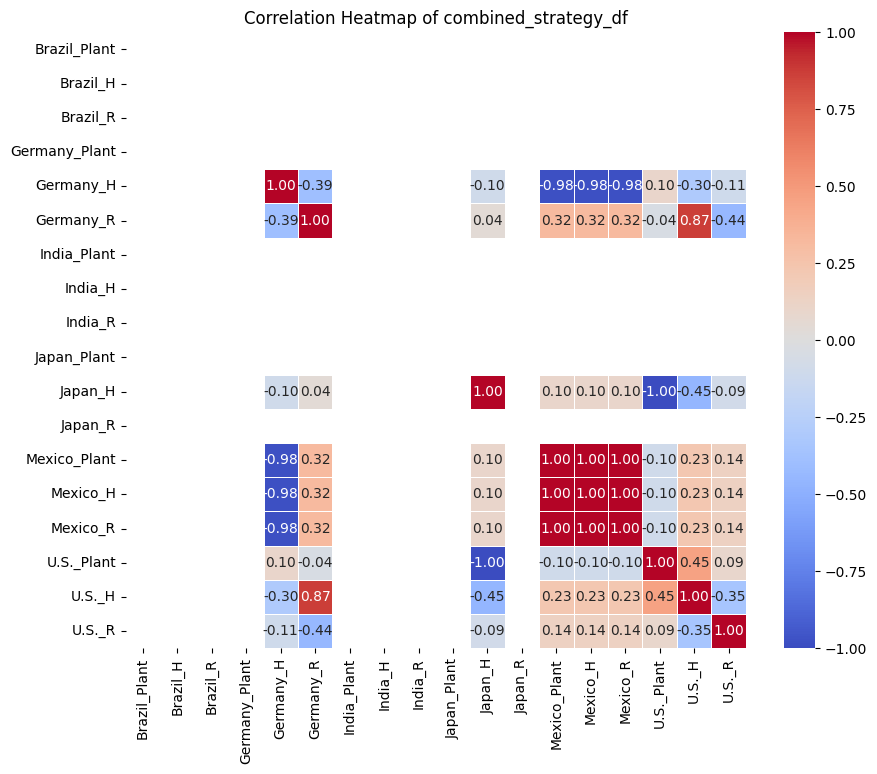

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming combined_strategy_df is your DataFrame
correlation_matrix = combined_strategy_df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Display the plot
plt.title('Correlation Heatmap of combined_strategy_df')
plt.show()


Based on the correlation heatmap, we can identify several pairs with high correlation:


*   Germany_H & Mexico: negatively correlated -0.98
*   Japan_H & US_plant: negatively correlated -1
*   Germany_R & US_H: positively correlated 0.87

The negatively correlated pair indicates that the two plants are most likely not to open at the same time.

The positively correlated pair indicated that the two plants are very likely to open as the same time.






# Question3: Computing expected strategy cost/and cost standard deviation

cannot find optimal solution if threshold = 1

In [ ]:
# strategy 1
fixed_plants = [
    [1, 1, 1],  # Brazil
    [1, 0, 1],  # Germany
    [1, 1, 1],  # India
    [1, 0, 1],  # Japan
    [0, 0, 0],  # Mexico
    [1, 1, 0]   # U.S.
]

# Store the minimum costs of all scenarios
min_costs = []

# Loop through each scenario in the exrate DataFrame
for scenario_index in range(100):
    try:
        # Create a Gurobi model
        model = Model("MinimizeCost")

        # Define decision variables
        dec_plant = {(i, j): model.addVar(vtype=GRB.BINARY, name=f"Dec_plant_{i}_{j}") for i in n_ctry for j in n_lines}
        dec_h = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"Dec_h_{i}_{j}") for i in n_ctry for j in n_ctry}
        dec_r = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"Dec_r_{i}_{j}") for i in n_ctry for j in n_ctry}

        # Add fixed plant constraints using numeric indices
        for i in n_ctry:
            for j in n_lines:
                model.addConstr(
                    dec_plant[i, j] == fixed_plants[i][j],
                    name=f"Fixed_Plant_{i}_{j}"
                )

        # Add capacity constraints
        excess_cap = calc_excess_cap(dec_plant, dec_h, dec_r)
        for i in n_ctry:
            for j in n_lines:
                model.addConstr(excess_cap[i, j] >= 0, name=f"Excess_Cap_Constraints_{i}_{j}")

        # Add demand constraints
        unmet_demand = calc_unmet_demand(dec_h, dec_r)
        for i in n_ctry:
            for j in range(2):  # For high-cal and relaxed coal demand
                model.addConstr(unmet_demand[i, j] == 0, name=f"Unmet_Demand_Constraints_{i}_{j}")

        # Set objective function
        model.setObjective(calc_total_cost(dec_plant, dec_h, dec_r, scenario_index), GRB.MINIMIZE)

        # Suppress optimization output
        model.Params.OutputFlag = 0

        # Optimize the model
        model.optimize()

        # Store the minimum cost of the scenario
        min_costs.append(model.objVal)

    except Exception as e:
        print(f"Error optimizing scenario {scenario_index}: {e}")
        continue

# Calculate the average and standard deviation of the minimum costs
avg_cost_1 = np.mean(min_costs)
std_cost_1 = np.std(min_costs)


In [ ]:
# strategy 2
fixed_plants = [
    [1, 1, 1],  # Brazil
    [1, 0, 1],  # Germany
    [1, 1, 1],  # India
    [1, 0, 1],  # Japan
    [1, 1, 1],  # Mexico
    [1, 1, 0]   # U.S.
]

# Store the minimum costs of all scenarios
min_costs = []

# Loop through each scenario in the exrate DataFrame
for scenario_index in range(100):
    try:
        # Create a Gurobi model
        model = Model("MinimizeCost")

        # Define decision variables
        dec_plant = {(i, j): model.addVar(vtype=GRB.BINARY, name=f"Dec_plant_{i}_{j}") for i in n_ctry for j in n_lines}
        dec_h = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"Dec_h_{i}_{j}") for i in n_ctry for j in n_ctry}
        dec_r = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"Dec_r_{i}_{j}") for i in n_ctry for j in n_ctry}

        # Add fixed plant constraints using numeric indices
        for i in n_ctry:
            for j in n_lines:
                model.addConstr(
                    dec_plant[i, j] == fixed_plants[i][j],
                    name=f"Fixed_Plant_{i}_{j}"
                )

        # Add capacity constraints
        excess_cap = calc_excess_cap(dec_plant, dec_h, dec_r)
        for i in n_ctry:
            for j in n_lines:
                model.addConstr(excess_cap[i, j] >= 0, name=f"Excess_Cap_Constraints_{i}_{j}")

        # Add demand constraints
        unmet_demand = calc_unmet_demand(dec_h, dec_r)
        for i in n_ctry:
            for j in range(2):  # For high-cal and relaxed coal demand
                model.addConstr(unmet_demand[i, j] == 0, name=f"Unmet_Demand_Constraints_{i}_{j}")

        # Set objective function
        model.setObjective(calc_total_cost(dec_plant, dec_h, dec_r, scenario_index), GRB.MINIMIZE)

        # Suppress optimization output
        model.Params.OutputFlag = 0

        # Optimize the model
        model.optimize()

        # Store the minimum cost of the scenario
        min_costs.append(model.objVal)

    except Exception as e:
        print(f"Error optimizing scenario {scenario_index}: {e}")
        continue

# Calculate the average and standard deviation of the minimum costs
avg_cost_2 = np.mean(min_costs)
std_cost_2 = np.std(min_costs)

In [ ]:
# Strategy 3
fixed_plants = [
    [1, 1, 1],  # Brazil
    [1, 1, 1],  # Germany
    [1, 1, 1],  # India
    [1, 0, 1],  # Japan
    [1, 1, 1],  # Mexico
    [1, 1, 0]   # U.S.
]

# Store the minimum costs of all scenarios
min_costs = []

# Loop through each scenario in the exrate DataFrame
for scenario_index in range(100):
    try:
        # Create a Gurobi model
        model = Model("MinimizeCost")

        # Define decision variables
        dec_plant = {(i, j): model.addVar(vtype=GRB.BINARY, name=f"Dec_plant_{i}_{j}") for i in n_ctry for j in n_lines}
        dec_h = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"Dec_h_{i}_{j}") for i in n_ctry for j in n_ctry}
        dec_r = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"Dec_r_{i}_{j}") for i in n_ctry for j in n_ctry}

        # Add fixed plant constraints using numeric indices
        for i in n_ctry:
            for j in n_lines:
                model.addConstr(
                    dec_plant[i, j] == fixed_plants[i][j],
                    name=f"Fixed_Plant_{i}_{j}"
                )

        # Add capacity constraints
        excess_cap = calc_excess_cap(dec_plant, dec_h, dec_r)
        for i in n_ctry:
            for j in n_lines:
                model.addConstr(excess_cap[i, j] >= 0, name=f"Excess_Cap_Constraints_{i}_{j}")

        # Add demand constraints
        unmet_demand = calc_unmet_demand(dec_h, dec_r)
        for i in n_ctry:
            for j in range(2):  # For high-cal and relaxed coal demand
                model.addConstr(unmet_demand[i, j] == 0, name=f"Unmet_Demand_Constraints_{i}_{j}")

        # Set objective function
        model.setObjective(calc_total_cost(dec_plant, dec_h, dec_r, scenario_index), GRB.MINIMIZE)

        # Suppress optimization output
        model.Params.OutputFlag = 0

        # Optimize the model
        model.optimize()

        # Store the minimum cost of the scenario
        min_costs.append(model.objVal)

    except Exception as e:
        print(f"Error optimizing scenario {scenario_index}: {e}")
        continue

# Calculate the average and standard deviation of the minimum costs
avg_cost_3 = np.mean(min_costs)
std_cost_3 = np.std(min_costs)

In [ ]:
# Data for strategies and thresholds
data = {
    'Threshold': ['0.9', '0.6', '0.3'],
    'Avg Min Cost ($)': [f"${avg_cost_1:.2f}", f"${avg_cost_2:.2f}", f"${avg_cost_3:.2f}"],
    'Std Dev of Min Cost ($)': [f"${std_cost_1:.2f}", f"${std_cost_2:.2f}", f"${std_cost_3:.2f}"],
}

# Create DataFrame
df = pd.DataFrame(data)

# Print the table
print(tabulate(df, headers='keys', tablefmt='pretty', showindex=False))


+-----------+------------------+-------------------------+
| Threshold | Avg Min Cost ($) | Std Dev of Min Cost ($) |
+-----------+------------------+-------------------------+
|    0.9    |     $1222.74     |         $22.11          |
|    0.6    |     $1188.88     |         $36.23          |
|    0.3    |     $1198.54     |         $35.53          |
+-----------+------------------+-------------------------+


Recommendation: We recommend Strategy 2 (0.33 < threshold < 0.68) with a lowest average minimum cost, which is shutting down the Highcal Production in Germany and Japan, and the Relax Production in the US.


| Country  | Plant  | H  | R  |
|--------|----|----|----|
| Brazil | 1  | 1  | 1  |
| Germany| 1  | 0  | 1  |
| India  | 1  | 1  | 1  |
| Japan  | 1  | 0  | 1  |
| Mexico | 1  | 1  | 1  |
| U.S.   | 1  | 1  | 0  |


This strategy aligns with the current situation of BioPharma,Inc. According to the case, the high costs of plants in Germany and Japan is the main reason for BioPharma to design a new network.